In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, LSTM, Bidirectional, Input, Concatenate
from tensorflow.keras import backend
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

In [36]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.6MB/s 


In [3]:
from tensorflow import keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [143]:
call_df=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/splitted_put.csv')
call_df=call_df.set_index(['Date'])
call_df=call_df[call_df['Close']>1]

In [144]:
call_df.head()

,Unnamed: 0,Unnamed: 0.1,Strike Price,Close,Expiration,Adj Close,return,volatility,Price,bs_put,implied_volatility,Moneyness_put
Date,,,,,,,,,,,,
2013-12-31,0,0,5800,6.30,30,6304.0,0.002051,0.135503,8.82,0.780877,0.401503,OTM
2013-12-31,1,1,5900,10.30,30,6304.0,0.002051,0.135503,8.82,2.667110,0.331503,OTM
2013-12-31,2,2,6000,17.15,30,6304.0,0.002051,0.135503,8.82,7.656025,0.267503,OTM
2013-12-31,3,3,6100,28.80,30,6304.0,0.002051,0.135503,8.82,18.756159,0.213503,OTM
2013-12-31,4,4,6200,49.10,30,6304.0,0.002051,0.135503,8.82,39.837882,0.172503,OTM


In [145]:
spot_df=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/spot_price/^NSEI.csv')
spot_df.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)
spot_df=spot_df.set_index(['Date'])
spot_df.dropna(inplace=True)

In [146]:
spot_df.head()

,Adj Close
Date,
2013-12-02,6217.850098
2013-12-03,6201.850098
2013-12-04,6160.950195
2013-12-05,6241.100098
2013-12-06,6259.899902


In [147]:
padded = np.insert(spot_df['Adj Close'].values, 0, np.array([np.nan] * 20))
rolled = np.column_stack([np.roll(padded, i) for i in range(20)])
rolled = rolled[~np.isnan(rolled).any(axis=1)]
rolled = np.column_stack((spot_df[19:], rolled))
price_history = pd.DataFrame(data=rolled)
price_history['date']=spot_df.index[19:]
price_history=price_history.set_index(['date'])
joined = call_df.join(price_history,how='inner')
joined.head(5)

,Unnamed: 0,Unnamed: 0.1,Strike Price,Close,Expiration,Adj Close,return,volatility,Price,bs_put,implied_volatility,Moneyness_put,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2013-12-31,0,0,5800,6.30,30,6304.0,0.002051,0.135503,8.82,0.780877,0.401503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,1,1,5900,10.30,30,6304.0,0.002051,0.135503,8.82,2.667110,0.331503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,2,2,6000,17.15,30,6304.0,0.002051,0.135503,8.82,7.656025,0.267503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,3,3,6100,28.80,30,6304.0,0.002051,0.135503,8.82,18.756159,0.213503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,4,4,6200,49.10,30,6304.0,0.002051,0.135503,8.82,39.837882,0.172503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098


In [116]:
joined_ITM = joined[joined["Moneyness_put"]=="ATM"]
joined_ITM.drop(["Moneyness_put"], axis=1, inplace=True)
joined = joined_ITM
call_ITM = call_df[call_df["Moneyness_put"]== "ATM"]
call_ITM = call_ITM.drop(["Moneyness_put"], axis=1)
joined.head(1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Unnamed: 0,Unnamed: 0.1,Strike Price,Close,Expiration,Adj Close,return,volatility,Price,bs_put,implied_volatility,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2013-12-31,5,5,6300,80.85,30,6304.0,0.002051,0.135503,8.82,74.553485,0.147503,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098


In [117]:
model_df=joined.drop(['return','volatility','bs_put'],axis=1)
model_df.head(1)

,Unnamed: 0,Unnamed: 0.1,Strike Price,Close,Expiration,Adj Close,Price,implied_volatility,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2013-12-31,5,5,6300,80.85,30,6304.0,8.82,0.147503,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098


In [118]:
def split_data(df):
  call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(df.drop(['Close'],axis=1).values,df['Close'].values,test_size=0.2,random_state=42)
  return call_X_train, call_X_test, call_y_train, call_y_test

In [119]:
call_X_train, call_X_test, call_y_train, call_y_test=split_data(model_df)
call_X_train.shape

(6625, 28)

In [120]:
N_TIMESTEPS = 20

call_X_train = [call_X_train[:, -N_TIMESTEPS:].reshape(call_X_train.shape[0], N_TIMESTEPS, 1), call_X_train[:, :4]]
call_X_test = [call_X_test[:, -N_TIMESTEPS:].reshape(call_X_test.shape[0], N_TIMESTEPS, 1), call_X_test[:, :4]]

call_X_train

[array([[[10482.200195],
         [10585.200195],
         [10598.400391],
         ...,
         [10584.75    ],
         [10512.5     ],
         [10472.5     ]],
 
        [[12045.799805],
         [12113.450195],
         [12174.650391],
         ...,
         [12180.349609],
         [12106.900391],
         [12169.849609]],
 
        [[11497.900391],
         [11598.25    ],
         [11712.25    ],
         ...,
         [11604.5     ],
         [11665.950195],
         [11598.      ]],
 
        ...,
 
        [[10792.5     ],
         [10862.549805],
         [10859.900391],
         ...,
         [10601.150391],
         [10782.900391],
         [10869.5     ]],
 
        [[ 8475.75    ],
         [ 8463.099609],
         [ 8530.150391],
         ...,
         [ 8169.200195],
         [ 8090.450195],
         [ 8027.600098]],
 
        [[ 9270.900391],
         [ 9205.599609],
         [ 9293.5     ],
         ...,
         [ 8748.75    ],
         [ 8792.200195],
         [ 

In [121]:
layers = 4
n_timesteps = 20
features = 4
n_batch = 400
n_epochs = 50

In [122]:
import kerastuner as kt

In [123]:
def model(hp):
    close_history = Input((n_timesteps, 1))
    input2 = Input((features,))
    
    lstm = Sequential()
    lstm.add(LSTM(units=8, input_shape=(n_timesteps, 1), return_sequences=True))
    
    for i in range(hp.Int('num_layers',2,8)):
      lstm.add(LSTM(units=hp.Int('units_LSTM_'+str(i),min_value=4,max_value=14,step=2),return_sequences=True))

    
    lstm.add(LSTM(units=8,return_sequences=False))
    input1 = lstm(close_history)
    
    connect = Concatenate()([input1, input2])
    
    for i in range(hp.Int('num_layers_dense',2,10)):
        connect = Dense(units=hp.Int('units_Dense_' + str(i),
                                            min_value=32,
                                            max_value=640,
                                            step=32))(connect)
        connect = BatchNormalization()(connect)
        connect = LeakyReLU()(connect)
    
    predict = Dense(1, activation='relu')(connect)

    new_model= Model(inputs=[close_history, input2], outputs=predict)
    new_model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4,1e-5])), loss='mse',metrics=['mse'])
    return new_model



In [124]:
tuner = kt.Hyperband(
    model,
    objective='mse',
    directory='/content/drive/MyDrive/Finance Project',
    project_name='HyperParameters_With_Resources',
    max_epochs=15,seed=42,
    factor=3)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Finance Project/HyperParameters_With_Resources/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Finance Project/HyperParameters_With_Resources/tuner0.json


In [125]:
tuner.search_space_summary()


Search space summary
Default search space size: 21
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': None}
units_LSTM_0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 14, 'step': 2, 'sampling': None}
units_LSTM_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 14, 'step': 2, 'sampling': None}
num_layers_dense (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_Dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 640, 'step': 32, 'sampling': None}
units_Dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 640, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}
units_LSTM_2 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 14, 'step': 2, 'sampling': None}
units_LSTM

In [126]:
tuner.search(call_X_train, call_y_train,epochs=15,validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


In [127]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [128]:
best_model=tuner.hypermodel.build(best_hps)
best_model.fit(call_X_train, call_y_train, epochs=20, validation_split=0.1)

Epoch 1/20
187/187 [==============================] - 35s 98ms/step - loss: 28326.1562 - mse: 28326.1562 - val_loss: 26439.8105 - val_mse: 26439.8105
Epoch 2/20
187/187 [==============================] - 15s 78ms/step - loss: 24870.0820 - mse: 24870.0820 - val_loss: 15140.0859 - val_mse: 15140.0859
Epoch 3/20
187/187 [==============================] - 15s 78ms/step - loss: 20499.5781 - mse: 20499.5781 - val_loss: 15966.7861 - val_mse: 15966.7861
Epoch 4/20
187/187 [==============================] - 15s 79ms/step - loss: 16161.7246 - mse: 16161.7246 - val_loss: 13260.5576 - val_mse: 13260.5576
Epoch 5/20
187/187 [==============================] - 15s 79ms/step - loss: 11996.5693 - mse: 11996.5693 - val_loss: 18151.4102 - val_mse: 18151.4102
Epoch 6/20
187/187 [==============================] - 15s 79ms/step - loss: 8798.7334 - mse: 8798.7334 - val_loss: 23417.7656 - val_mse: 23417.7656
Epoch 7/20
187/187 [==============================] - 15s 79ms/step - loss: 7255.1426 - mse: 7255.1426

In [129]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8)            8464        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12)           0           sequential[0][0]                 
                                                                 input_2[0][0]                

In [130]:
best_model.save('/content/drive/MyDrive/black_scholes_option_pricing/HyperParameters_With_Resources/lstm_resource_model.h5')


In [131]:
y_pred_new=best_model.predict(call_X_test)
y_pred_new.shape

(1657, 1)

In [132]:
y_pred_new

array([[ 86.56585 ],
       [ 33.95974 ],
       [ 38.73599 ],
       ...,
       [172.87279 ],
       [ 92.069374],
       [  0.      ]], dtype=float32)

In [133]:
y_pred_train=best_model.predict(call_X_train)

In [134]:
y_pred_train.shape

(6625, 1)

In [135]:
call_X_train_tm, call_X_test_tm, call_y_train_tm, call_y_test_tm = train_test_split(call_df.drop(['Close'],axis=1),call_df['bs_put'],test_size=0.2,random_state=42)

In [136]:
call_y_test_tm

Date
2020-10-06     54.126364
2016-09-02     28.048132
2016-05-02      8.558845
2014-07-30    370.094769
2020-04-13     35.063440
                 ...    
2020-03-17    632.675043
2017-09-20    104.701435
2020-02-11    153.540536
2014-01-15      0.859090
2020-11-10    563.542718
Name: bs_put, Length: 11000, dtype: float64

In [137]:
from sklearn.metrics import r2_score
r2_score(list (call_X_test_tm["bs_put"]),y_pred_new)

ValueError: ignored

In [138]:
x=np.array(call_y_test).reshape(-1,1)
y=np.array(y_pred).reshape(-1,1)
reg=LinearRegression().fit(x,y_pred_new)
mae= mean_absolute_error(x,y_pred_new)
print(reg.score(x,y_pred_new),mae)

NameError: ignored

In [139]:
r2_score(call_y_train,y_pred_train)


-1.0180613355392873

In [140]:
call_X_test_tm["bs_put"]

Date
2020-10-06     54.126364
2016-09-02     28.048132
2016-05-02      8.558845
2014-07-30    370.094769
2020-04-13     35.063440
                 ...    
2020-03-17    632.675043
2017-09-20    104.701435
2020-02-11    153.540536
2014-01-15      0.859090
2020-11-10    563.542718
Name: bs_put, Length: 11000, dtype: float64

In [141]:
from sklearn.metrics import mean_absolute_error
print('mse: ',mean_absolute_error(call_y_test ,y_pred_new))
from sklearn.metrics import mean_squared_error
print('mae: ',mean_squared_error(call_y_test ,y_pred_new))

mse:  103.26240101090814
mae:  21520.577827583915


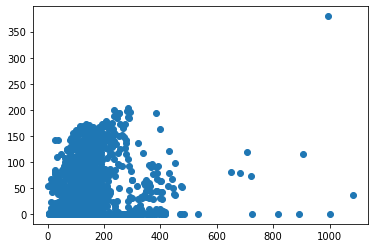

In [142]:
x=np.array(call_y_test).reshape(-1,1)
y=np.array(y_pred_new).reshape(-1,1)
reg=LinearRegression().fit(x,y)
mae= mean_absolute_error(x,y)
plt.scatter(x,y)

In [ ]:
print(reg.score(x,y))